----------- 0 times -----------


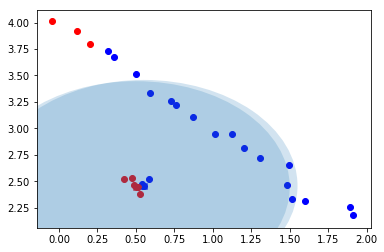

step  0	loglikelihood = 13.430117226651666


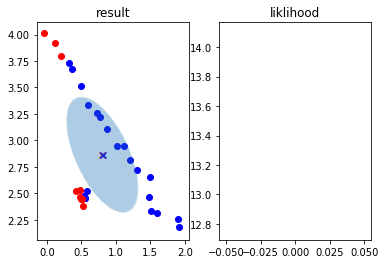

step  1	loglikelihood = 13.43077970343305


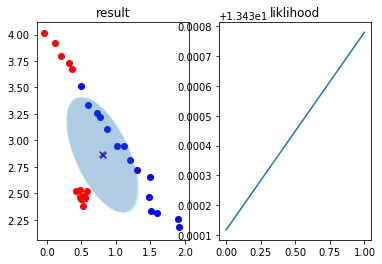

step  2	loglikelihood = 13.432328844446376


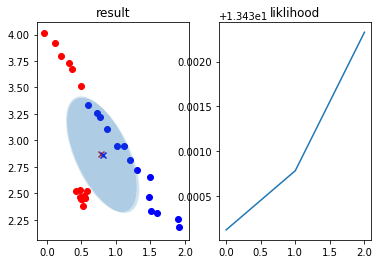

step  3	loglikelihood = 13.43607862487576


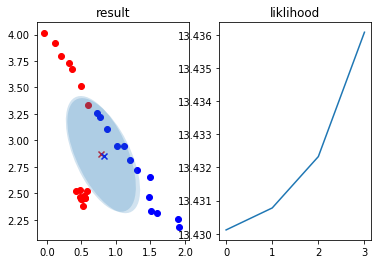

step  4	loglikelihood = 13.445301895560007


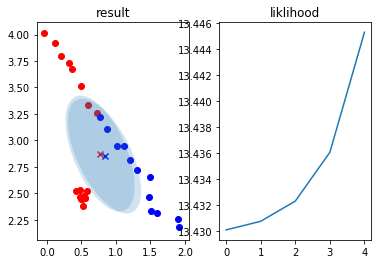

step  5	loglikelihood = 13.468299773179341


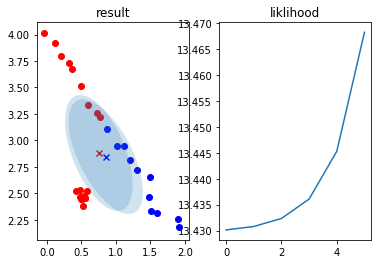

step  6	loglikelihood = 13.526730813317535


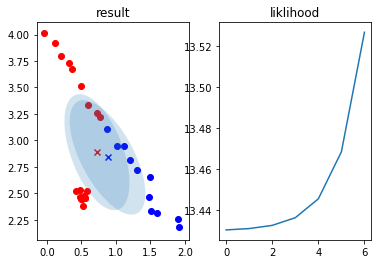

step  7	loglikelihood = 13.680350121110335


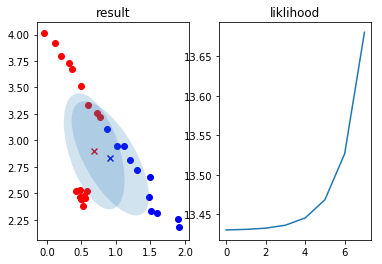

step  8	loglikelihood = 14.112114958782502


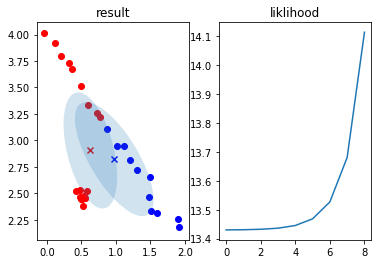

step  9	loglikelihood = 15.48441248735103


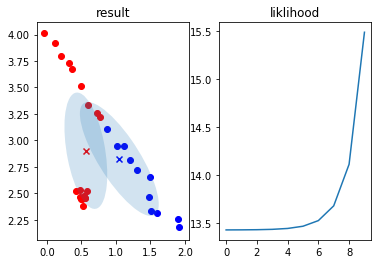

step 10	loglikelihood = 20.591164429091027


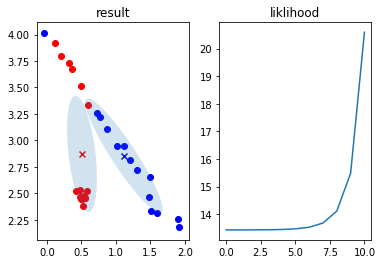

step 11	loglikelihood = 30.514279563463447


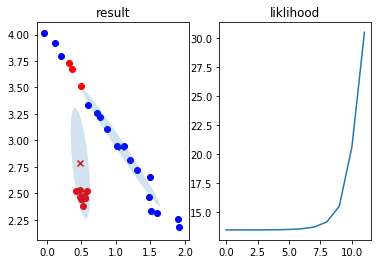

step 12	loglikelihood = 38.17665161072197


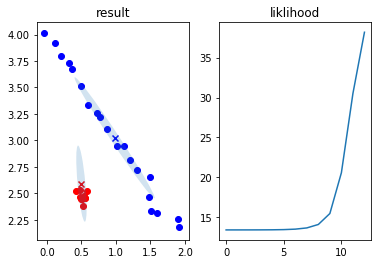

step 13	loglikelihood = 50.607668761441424


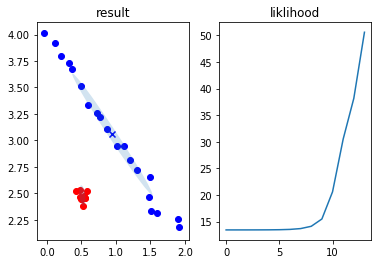

step 14	loglikelihood = 54.67910879401283


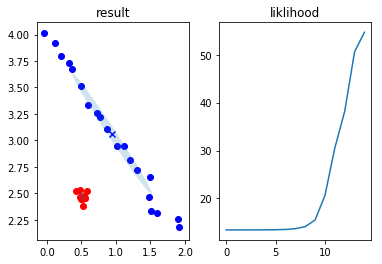

step 15	loglikelihood = 54.67910879401283


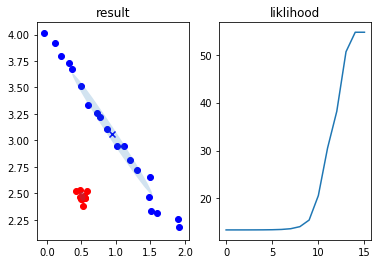

step 16	loglikelihood = 54.67910879401283


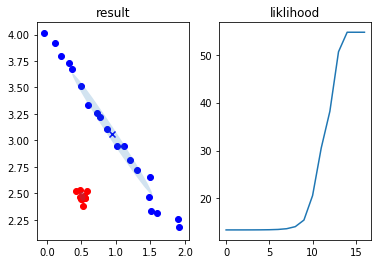

step 17	loglikelihood = 54.67910879401283


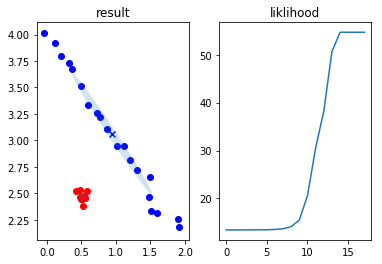

step 18	loglikelihood = 54.67910879401283


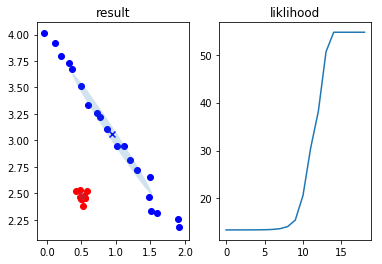

step 19	loglikelihood = 54.67910879401283


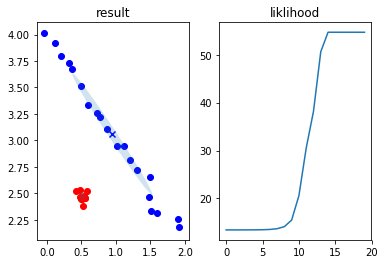

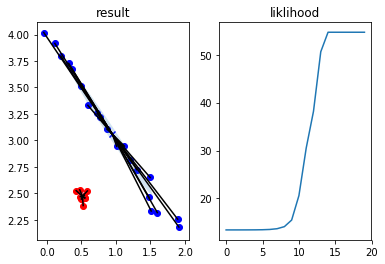

----------- 1 times -----------


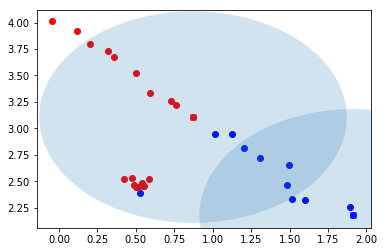

step  0	loglikelihood = 13.976235613140615


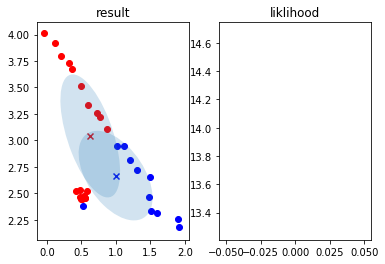

step  1	loglikelihood = 14.699875153727644


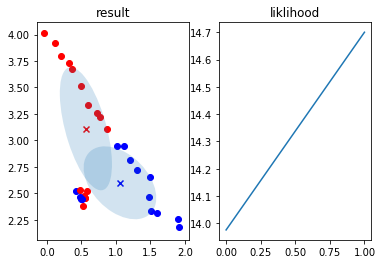

step  2	loglikelihood = 15.702792749053524


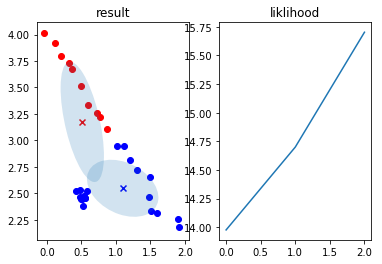

step  3	loglikelihood = 16.327109327355487


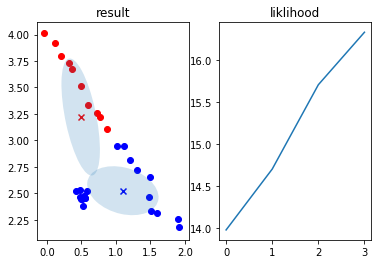

step  4	loglikelihood = 16.558419232106175


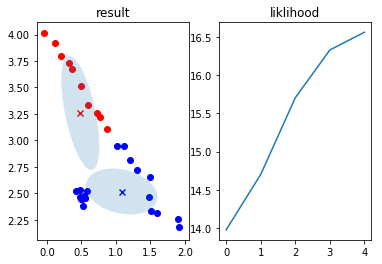

step  5	loglikelihood = 16.78477496371787


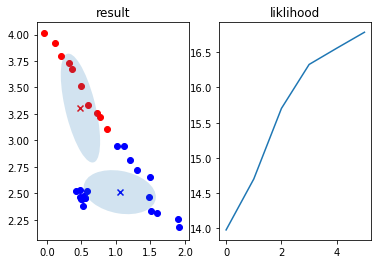

step  6	loglikelihood = 17.573289486243386


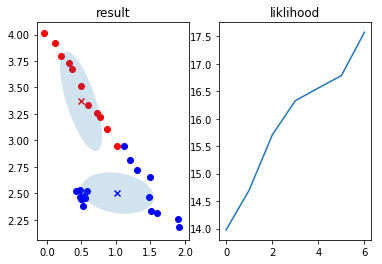

step  7	loglikelihood = 21.86487909417237


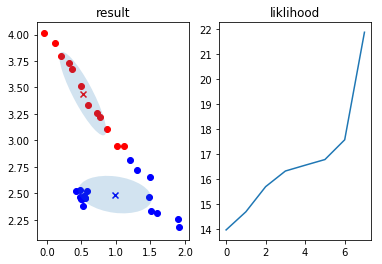

step  8	loglikelihood = 34.084594669655615


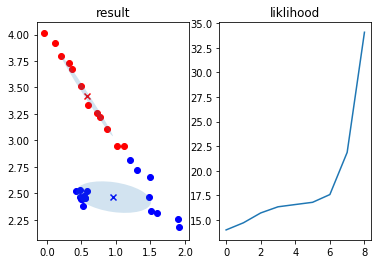

step  9	loglikelihood = 36.63307378381077


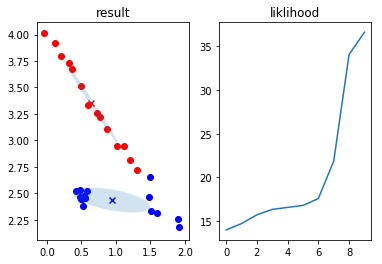

step 10	loglikelihood = 37.32930534987883


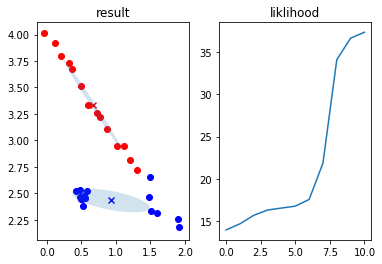

step 11	loglikelihood = 37.42605474863361


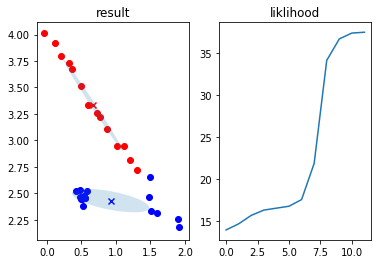

step 12	loglikelihood = 37.60292062228


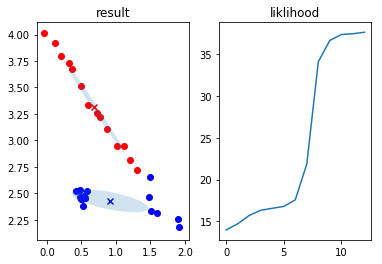

step 13	loglikelihood = 38.64608281861863


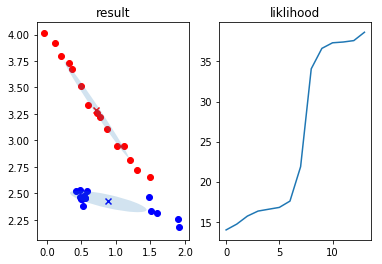

step 14	loglikelihood = 39.84220067006519


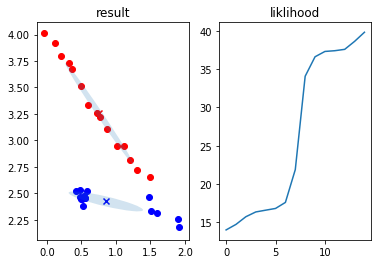

step 15	loglikelihood = 40.34071452923321


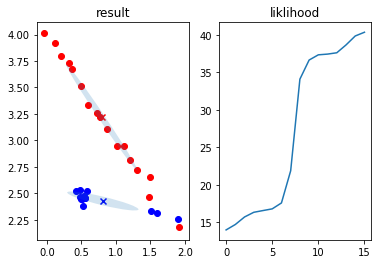

step 16	loglikelihood = 40.49115525185232


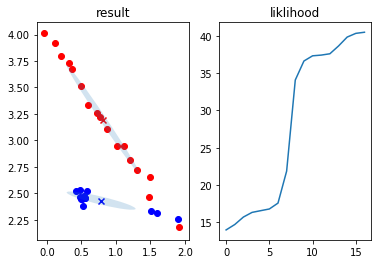

step 17	loglikelihood = 40.51011283301774


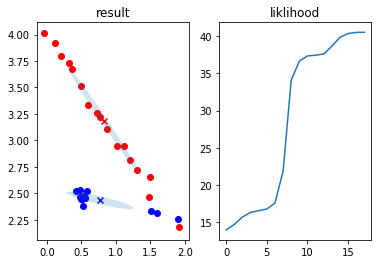

step 18	loglikelihood = 40.50854585154424


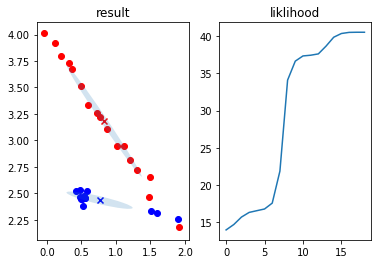

step 19	loglikelihood = 40.50267952696595


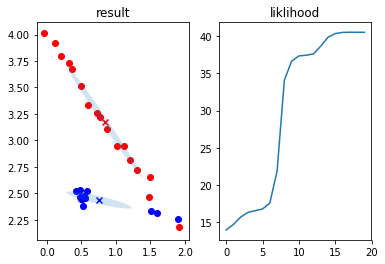

----------- 2 times -----------


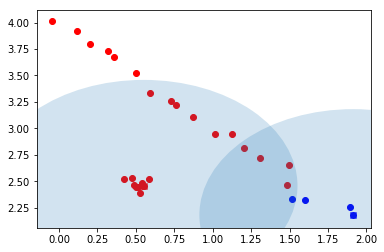

step  0	loglikelihood = 13.737788499757677


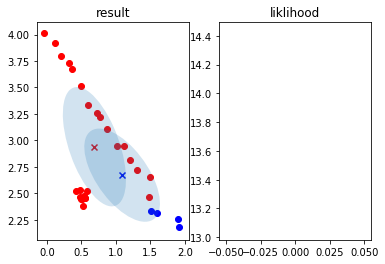

step  1	loglikelihood = 14.154773389324445


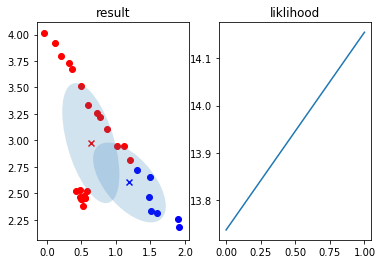

step  2	loglikelihood = 14.90596823538874


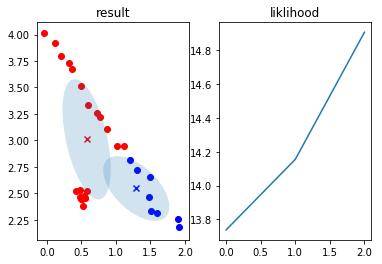

KeyboardInterrupt: 

In [2]:
import numpy
import random
import math
import pylab
import matplotlib
import matplotlib.pyplot as plt

def draw_data( data, classes, mus, sigmas, colors = ("r" , "b" , "g" , "c" , "m" , "y" , "k" )):
    #pylab.clf()

    for d,k in zip(data, classes):
        pylab.scatter( d[0] , d[1] , color=colors[k] )

    # mean
    for i,m in enumerate(mus):
        pylab.scatter( m[0] , m[1] , color=colors[i] , marker="x" )

    # std
    def to_transform(mu, sigma):
        val, vec = numpy.linalg.eigh(sigma)
        trans = numpy.diag(numpy.sqrt(val)).dot(vec)
        return matplotlib.transforms.Affine2D.from_values(*trans.flatten(), e=mu[0], f=mu[1])

    ax = pylab.gca()
    circles = [pylab.Circle((0, 0), radius=1, transform=to_transform(mu, sigma)) for mu, sigma in zip(mus, sigmas)]
    ax.add_collection( matplotlib.collections.PatchCollection(circles, alpha=0.2))

def draw_line( p1 , p2 , color="k" ):
    pylab.plot( [p1[0], p2[0]] , [p1[1],p2[1]], color=color )

def calc_gauss_pdf(x, mu, sigma):

    # normalization
    C = 1 / (math.pow(2 * math.pi, len(x)/2.0) * math.pow(numpy.linalg.det(sigma), 1.0/2.0))

    # x - mu
    x_mu = numpy.matrix(x-mu)

    # exp
    P = numpy.exp(-0.5 * x_mu * numpy.linalg.inv(sigma) * x_mu.T)
    return float(C * P)

def E_step( data, mus, sigmas, alphas ):
    K = len(mus)
    P = numpy.zeros( (len(data), K) )

    # compute prob for each class
    for d in range(len(data)):
        for k in range(K):
            P[d][k] = alphas[k] * calc_gauss_pdf( data[d] , mus[k] , sigmas[k] )
        P[d] = P[d] / numpy.sum(P[d])

    return P

def M_step( data, P ):
    K = len(P[0])
    N = P.sum(0)
    dim = len(data[0])

    mus = [ numpy.zeros(dim) for k in range(K) ]
    sigmas = [ numpy.zeros((dim,dim)) for k in range(K) ]

    # compute mean
    for k in range(K):
        for d in range(len(data)):
            mus[k] += P[d,k] * data[d]
        mus[k] /= N[k]

    # compute std
    for k in range(K):
        for d in range(len(data)):
            sigmas[k] += P[d,k] * (data[d]-mus[k]).reshape(dim,1) * (data[d]-mus[k]).reshape(1,dim)
        sigmas[k] /= N[k]

    # compute mixed ratio
    alphas = N / N.sum()

    return mus, sigmas, alphas

def calc_logliklihood( data, mus, sigmas, alphas ):
    lik = 0
    for d in range(len(data)):
        sum = 0
        for k in range(len(mus)):
            sum += alphas[k] + calc_gauss_pdf( data[d] , mus[k] , sigmas[k] )
        lik += numpy.log( sum )

    return lik

def gmm( data, K, num_trial=1 ):
    pylab.ion()

    dim = len(data[0])

    # max likelihood
    max_lik = -99999

    # gaussian parameters
    mus = [ None for k in range(K) ]
    sigmas = [ None for k in range(K) ]
    alphas = [ 1.0/K for k in range(K) ]

    for i in range(num_trial):
        print("----------- %d times -----------" % (i))

        # initialization
        for k in range(K):
            mus[k] = data[random.randint(0,len(data)-1)]  
            sigmas[k] = numpy.eye(dim)                   

        # classify with init value
        P = E_step( data , mus, sigmas, alphas )
        classes = numpy.argmax( P , 1 )

        draw_data( data, classes, mus, sigmas )
        pylab.draw()
        pylab.pause(1.0)

        lik = 0
        liks = []
        for j in range(20):

            # EM algorithm
            P = E_step( data , mus, sigmas, alphas )
            mus, sigmas, alphas = M_step( data , P )

            # clustering results
            classes = numpy.argmax( P , 1 )

            # compute likelihood
            lik = calc_logliklihood( data, mus, sigmas, alphas )
            liks.append( lik )

            print("step {0:2d}\tloglikelihood = {1}".format(j, lik))

            pylab.clf()
            pylab.subplot("121")
            pylab.title("result")
            draw_data( data, classes, mus, sigmas )
            pylab.subplot("122")
            pylab.title( "liklihood" )
            pylab.plot( range(len(liks)) , liks )
            pylab.draw()
            pylab.pause(1.0)


        if lik>max_lik:
            pylab.ioff()
            pylab.clf()
            pylab.subplot("121")
            pylab.title("result")
            draw_data( data, classes, mus, sigmas )
            for d,k in zip(data,classes):
                draw_line( d , mus[k] )
            pylab.subplot("122")
            pylab.title( "liklihood" )
            pylab.plot( range(len(liks)) , liks )
            pylab.show()

            # update
            max_lik = lik


def main():
    data = numpy.loadtxt( "gmm_sample_data.txt" )
    gmm( data , 2, 5 )

if __name__ == '__main__':
    main()
